<a href="https://colab.research.google.com/github/Klingefjord/notebooks/blob/main/names_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A names transformer

A decoder-only transformer (actually built up of TransformerEncoder blocks in PyTorch, since the PyTorch TransformerDecoder blocks contain encoder-decoder attention layers. Otherwise similar to GPT), trained on character-level name generation. The model is fed thousands of names masked triangularily, and tries to predict the next character in the name.

# Setup

In [3]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2022-10-20 11:57:11--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2022-10-20 11:57:11 (10.8 MB/s) - ‘names.txt’ saved [228145/228145]



In [73]:
import os
import math
import torch
import random
import numpy as np
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [74]:
def seed_torch(seed=1029):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

seed_torch()

# Model

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        torch.Size([128, 9, 29])
        torch.Size([5000, 1, 512])
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TransformerEncoder(nn.Module):
  def __init__(self, n_layers: int, d_model: int, n_heads: int, vocab_size: int):
    super(TransformerEncoder, self).__init__()
    self.d_model = d_model
    self.src_embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encodings = PositionalEncoding(d_model, dropout=0.1)
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=True, dropout=0.1)
    self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
    self.generator = nn.Linear(d_model, vocab_size)
    self.init_weights()

  def init_weights(self) -> None:
    initrange = 0.1
    self.src_embedding.weight.data.uniform_(-initrange, initrange)
    self.generator.bias.data.zero_()
    self.generator.weight.data.uniform_(-initrange, initrange)

  def forward(self, x: Tensor, src_mask: Tensor, padding_mask: Tensor) -> Tensor:
    x = self.src_embedding(x) * math.sqrt(self.d_model)
    x = self.pos_encodings(x)
    x = self.encoder(x, src_mask, padding_mask)
    x = self.generator(x)
    return x

# Data

In [21]:
words = open('names.txt', 'r').read().splitlines()
words = sorted(words, key=len)

vocab = [':',';','_','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stoi = {key:i for i, key in enumerate(vocab)}
itos = {i:key for i, key in enumerate(vocab)}

# configure the vocabulary
# : = start
# ; = end
# _ = pad
vocab = [':',';','_','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stoi = {key:i for i, key in enumerate(vocab)}
itos = {i:key for i, key in enumerate(vocab)}

In [22]:
class NamesDataset(Dataset):
    def __init__(self, names):
        self.names = names
        self.max_len = len(names[-1]) + 2

    def __len__(self):
        return len(self.names)
        
    def __getitem__(self, idx):
        name = itos[0] + self.names[idx] + itos[1]
        word = torch.tensor([stoi[n] for n in name])
        pad  = torch.tensor([2 for _ in range(self.max_len - len(name))])
        return torch.cat((word, pad)).long()

In [23]:
split = int(len(words) * 0.8)

train_data = NamesDataset(words[:split])
test_data = NamesDataset(words[split:])

# Training Setup

In [129]:
@torch.no_grad()
def greedy_decode(model, max_tokens, device):
  idx = torch.tensor([[0]]).long().to(device)

  model.eval()

  for _ in range(max_tokens):
    src_mask = torch.triu(torch.ones(idx.shape[-1], idx.shape[-1]) * float('-inf'), diagonal=1).to(device)
    logits = model(idx, src_mask, None) # no padding token in inference mode.
    next_token_logits = logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1)
    next_tokens = torch.multinomial(probs, num_samples=1)
    idx = torch.cat((idx, next_tokens), dim=1)

    if idx.squeeze()[-1] == 1 or idx.squeeze()[-1] == 2:
      break
  
  if (idx.squeeze().numel() < 1):
    return

  idx = idx.squeeze()[1:] # trim away the <bos> token.
  idx = idx.squeeze()[:-1] # trim away the <eos> token.
  
  print(''.join([itos[i] for i in idx.tolist()]))


def collate_fn(x, n_tokens_input=3, pad=2):
  x = torch.stack(x)
  src = x[:, :-1]
  tgt = x[:, 1:]

  src_mask = torch.triu(torch.ones(src.shape[-1], src.shape[-1]) * float('-inf'), diagonal=1)
  padding_mask = (src == pad)

  return (src.to(device), tgt.to(device), src_mask.to(device), padding_mask.to(device))

In [113]:
def plot_losses(train_losses, valid_losses):
  """Plot the training and validation losses against the epoch"""
  plt.plot(train_losses)
  plt.plot(valid_losses)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def train_epoch(model, optimizer, dataloader):
  losses = []

  model.train()

  i = 0

  for src, tgt, src_mask, padding_mask in dataloader:

    out = model(src, src_mask, padding_mask)
    loss = criterion(out.permute(0, 2, 1), tgt)

    # visualize in, out and tgt.
    #
    #print("out shape", out.shape)
    #print("tgt shape", tgt.shape)
    #if i % 10 == 0:
    #  print("in", "".join([itos[a] for a in src[0, :].squeeze().tolist()]))
    #  print("target", "".join([itos[a] for a in tgt[0, :].squeeze().tolist()]))
    #  print("out", "".join([itos[a] for a in torch.argmax(out[0, :].squeeze(), dim=-1).tolist()]))
    #i += 1

    optimizer.zero_grad()
    model.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    losses.append(loss)

  return losses

@torch.no_grad()
def val_epoch(model, dataloader, device):
  losses = []

  model.eval()

  for src, tgt, src_mask, padding_mask in dataloader:
    out = model(src, src_mask, padding_mask)
    loss = criterion(out.permute(0, 2, 1), tgt)
    losses.append(loss)

  return losses

def train(model, epochs, optimizer, scheduler, train_loader, test_loader, device):
  """Train the model for {epochs} epochs"""
  train_loss = []
  val_loss   = []

  for e in range(epochs):
    train_loss += train_epoch(model, optimizer, train_loader)
    val_loss += val_epoch(model, test_loader, device)

    if scheduler is not None:
      scheduler.step()

    print(f"Epoch {e}\t Train Loss: {train_loss[-1]}\t Val Los: {val_loss[-1]}")

  plot_losses([l.clone().detach().cpu() for l in train_loss], [l.clone().detach().cpu() for l in val_loss])

# Activations

Verifying that the activations after a dry run of the model look fairly gaussian.

layer 0 (Linear(in_features=200, out_features=2048, bias=True)): mean -0.00, std 0.58, saturated: 8.93%
layer 1 (Linear(in_features=2048, out_features=200, bias=True)): mean -0.02, std 0.25, saturated: 0.00%
layer 2 (Linear(in_features=200, out_features=2048, bias=True)): mean +0.00, std 0.58, saturated: 9.40%
layer 3 (Linear(in_features=2048, out_features=200, bias=True)): mean -0.03, std 0.25, saturated: 0.00%
layer 4 (Linear(in_features=200, out_features=29, bias=True)): mean -0.26, std 0.73, saturated: 19.21%


Text(0.5, 1.0, 'activation distribution')

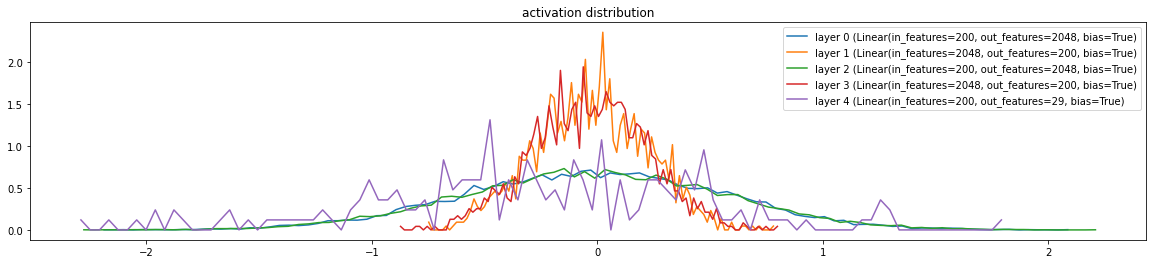

In [35]:
#
# Verify that the activations in the model look decent (close to gaussian).
#

eval_model = TransformerEncoder(n_layers=2, d_model=200, n_heads=2, vocab_size=len(vocab))

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# add the hooks
for m in eval_model.modules():
  if isinstance(m, nn.Linear):
    m.register_forward_hook(get_activation(m))

# perform a forward pass
eval_model.to(torch.device('cpu'))
eval_model.eval()

x = torch.tensor([stoi[s] for s in ':oliver']).unsqueeze(0)
sz = x.shape[-1]
m = torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

_ = eval_model(x, m, None)  

# visualize the activations
plt.figure(figsize=(20, 4))
legends = []

for i, key in enumerate(activations):
  t = activations[key]
  if isinstance(t, tuple):
    break
  print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, key, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
  hy, hx = torch.histogram(t, density=True)
  plt.plot(hx[:-1].detach(), hy.detach())
  legends.append(f'layer {i} ({key}')
plt.legend(legends);
plt.title('activation distribution')

Not perfect, but close enough given that the model has LayerNorm layers.

# Training

Epoch 0	 Train Loss: 1.9155009984970093	 Val Los: 1.401049017906189
Epoch 1	 Train Loss: 1.7460925579071045	 Val Los: 1.345306396484375
Epoch 2	 Train Loss: 1.845577597618103	 Val Los: 1.4650746583938599
Epoch 3	 Train Loss: 1.9261986017227173	 Val Los: 1.4231321811676025
Epoch 4	 Train Loss: 1.8000415563583374	 Val Los: 1.4585118293762207
Epoch 5	 Train Loss: 1.6985405683517456	 Val Los: 1.4223273992538452
Epoch 6	 Train Loss: 1.8189648389816284	 Val Los: 1.3757801055908203
Epoch 7	 Train Loss: 1.6562831401824951	 Val Los: 1.3567101955413818
Epoch 8	 Train Loss: 1.7626031637191772	 Val Los: 1.2761435508728027
Epoch 9	 Train Loss: 1.7388361692428589	 Val Los: 1.3576894998550415
Epoch 10	 Train Loss: 1.7631278038024902	 Val Los: 1.3902767896652222
Epoch 11	 Train Loss: 1.705020785331726	 Val Los: 1.3265857696533203
Epoch 12	 Train Loss: 1.7156494855880737	 Val Los: 1.2686419486999512
Epoch 13	 Train Loss: 1.6929904222488403	 Val Los: 1.4362232685089111
Epoch 14	 Train Loss: 1.6425963640

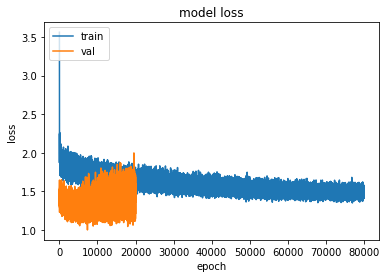

In [145]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, drop_last=True, collate_fn=collate_fn)

lr = 1e-3
model = TransformerEncoder(n_layers=2, d_model=200, n_heads=2, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

train(
    model, epochs=epochs, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    train_loader=train_loader, 
    test_loader=test_loader,
    device=device)

# Evaluation

In [146]:
for _ in range(20):
  greedy_decode(model, 10, device)

sandy
elyston
sona
alexz
jayman
joby
amilia
naiama
keelin
kim
kiarah
keng
bohdi
carital
geano
ellanie
jatalynn
suza
arun
aaloika


In [147]:
gen_names = [
"sandy",
"elyston",
"sona",
"alexz",
"jayman",
"joby",
"amilia",
"naiama",
"keelin",
"kim",
"kiarah",
"keng",
"bohdi",
"carital",
"geano",
"ellanie",
"jatalynn",
"suza",
"arun",
"aaloika",
]

for n in gen_names:
  print(f"{n}\t Exists in dataset: {n in words}")

sandy	 Exists in dataset: True
elyston	 Exists in dataset: False
sona	 Exists in dataset: True
alexz	 Exists in dataset: False
jayman	 Exists in dataset: False
joby	 Exists in dataset: True
amilia	 Exists in dataset: True
naiama	 Exists in dataset: False
keelin	 Exists in dataset: True
kim	 Exists in dataset: True
kiarah	 Exists in dataset: True
keng	 Exists in dataset: True
bohdi	 Exists in dataset: True
carital	 Exists in dataset: False
geano	 Exists in dataset: False
ellanie	 Exists in dataset: True
jatalynn	 Exists in dataset: False
suza	 Exists in dataset: False
arun	 Exists in dataset: True
aaloika	 Exists in dataset: False
